# Echo State Network
## Assignment 1: NARMA10 task

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics import mean_squared_error

Load the datset

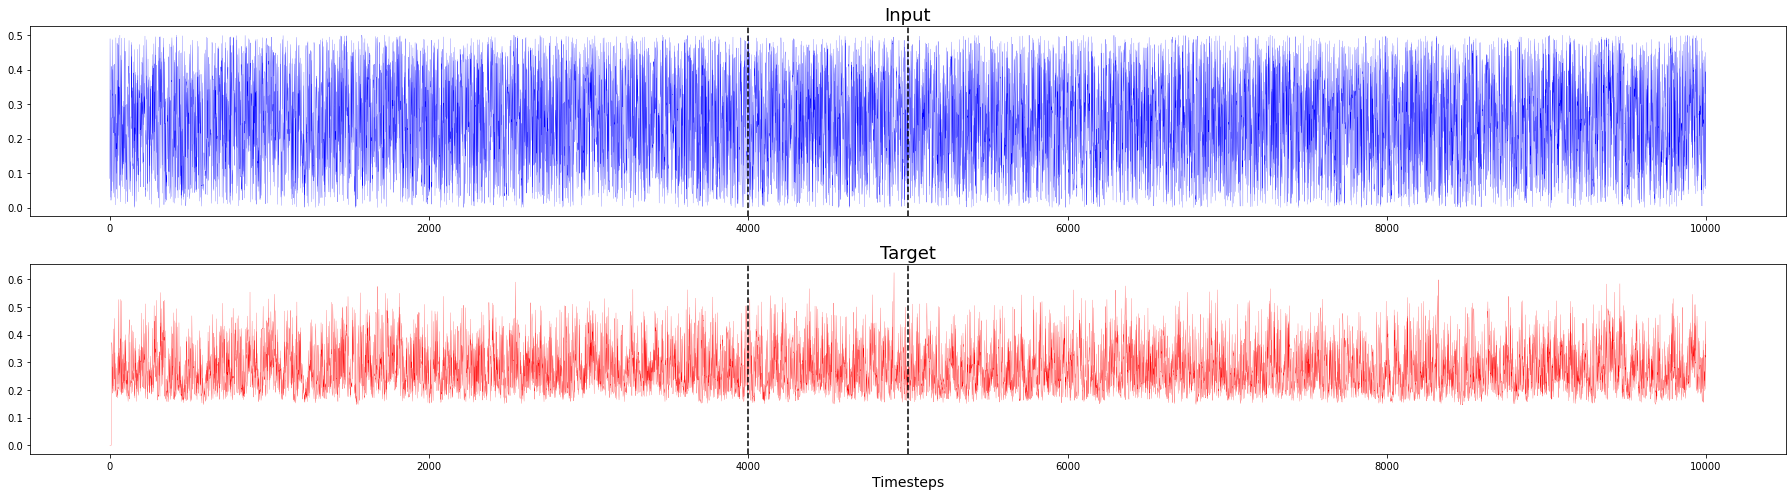

In [3]:
#load the data
x, y = np.loadtxt("NARMA10.csv", delimiter=",")


#split the dataset into training, validation and test
x_train = x[:4000]
x_valid = x[4000:5000] 
x_test = x[5000:]

y_train = y[:4000]
y_valid = y[4000:5000]
y_test = y[5000:]

#plot the data
plt.figure(figsize = (25,7))
ax1 = plt.subplot(211)
plt.title('Input', fontsize=18)
ax1.plot(x, color = 'b', linewidth= 0.2)
ax1.axvline(x = 4000, color = 'black', linestyle= '--')
ax1.axvline(x = 5000, color = 'black', linestyle= '--')

ax2 = plt.subplot(212, sharex = ax1)
plt.title('Target', fontsize=18)
ax2.plot(y, color = 'r', linewidth = 0.2)
ax2.axvline(x = 4000, color = 'black', linestyle= '--')
ax2.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)
plt.tight_layout()

## Implement the ESN

We consider as hyperparameters of the model:
- number of reservoir neurons
- spectral radius
- input scaling
- bias scaling
- readout regularization
- sparsity of Wx
- sparsity of Wh

In [4]:
def esn (hyperparams, ntrials=1, plot=False, steps_to_plot=200, test=False, save = False):
    #unpack array of hyperparameters:
    Nh = int(hyperparams[0])
    rho = hyperparams[1]
    omega_x = hyperparams[2]
    omega_b = hyperparams[3]
    l = hyperparams[4]
    dx = hyperparams[5]
    dh = hyperparams[6]

    Nx = 1 #input is 1-dimentional

    # For each hyper-parameterization, the performance
    # should be averaged over a number (ntrials) of reservoir guesses
    
    valid_mse_hist = [] #to keep track of validation mse on different random instances of the ESN

    for i in range (ntrials):
        # Initialize weights Wx and Wh
        Wx = sparse.rand(Nh, Nx, density=dx)
        Wx.data = 2 * Wx.data - 1
        Wx = Wx.toarray()
        Wx = omega_x * Wx

        Wh = sparse.rand(Nh, Nh, density=dh)
        Wh.data = 2 * Wh.data - 1
        Wh = Wh.toarray()
        Wh = rho * (Wh / np.max(np.abs(np.linalg.eig(Wh)[0])))


        # bias (initialized such that its nonzero elements match nonzero elements of Wx)
        b = np.zeros((Nh, Nx))
        # find the indices where Wx is different than 0
        indices = np.nonzero(Wx)[0]
        for j in indices:
            b[j] = np.random.rand()
        b[indices] = 2 * b[indices] - 1
        b = omega_b * b


        #Run the reservoir on the input stream

        # Initialize state vector and hidden state history
        state = np.zeros((Nh, 1))
        H = state.copy()

        for t in range(len(x_train)):
            state = np.tanh(Wh.dot(state) + Wx.dot(x_train[t]) + b)
            H = np.hstack((H, state))


        #discard the washout
        washout_size = 100 #va bene tenerlo costante
        H = H[:, (washout_size+1):]
        Y = y_train[washout_size:]

        #train the readout using ridge regression
        Wo = np.dot(np.dot(Y,H.T),np.linalg.inv(np.dot(H,H.T)+l*np.identity(len(np.dot(H,H.T)))))

        #save the esn variables
        if save == True:
            np.save('Wx',Wx)
            np.save('Wh',Wh)
            np.save('Wo',Wo)
            np.save('b',b)

        #compute output

        o_tr = np.dot(Wo, H)
        err_tr = mean_squared_error(Y, o_tr)

        if plot == True :    
            plt.figure(figsize = (25,7))
            plt.subplot(211)
            plt.title(f'TRAINING - MSE = {err_tr}')
            plt.plot(o_tr, color = 'r', linewidth = 0.3, label='Output')
            plt.plot(Y, color = 'black', linewidth = 0.3, label='Target')
            plt.legend()
            plt.subplot(212)
            plt.title(f'First {steps_to_plot} steps')
            plt.plot(o_tr[:steps_to_plot], color = 'r', linewidth = 1, label='Output')
            plt.plot(Y[:steps_to_plot], color = 'black', linewidth = 1, label='Target')
            plt.legend()
            plt.savefig('training.pdf')

        #validation 

        H = state

        for t in range(len(x_valid)):
            state = np.tanh(Wh.dot(state) + Wx.dot(x_valid[t]) + b)
            H = np.hstack((H, state))

        H = H[:, 1:]

        o_valid = np.dot(Wo, H)
        err_valid = mean_squared_error(y_valid, o_valid)

        if plot == True:
            plt.figure(figsize = (25,7))
            plt.subplot(211)
            plt.title(f'VALIDATION - MSE = {err_valid}')
            plt.plot(o_valid, color = 'r', linewidth = 0.3, label='Output')
            plt.plot(y_valid, color = 'black', linewidth = 0.3, label='Target')
            plt.legend()
            plt.subplot(212)
            plt.title(f'First {steps_to_plot} steps')
            plt.plot(o_valid[:steps_to_plot], color = 'r', linewidth = 1, label='Output')
            plt.plot(y_valid[:steps_to_plot], color = 'black', linewidth = 1, label='Target')
            plt.legend()
            plt.savefig('validation.pdf')
        

        valid_mse_hist.append(err_valid)

        #test

        if test == True:
            H = state

            for t in range(len(x_test)):
                state = np.tanh(Wh.dot(state) + Wx.dot(x_test[t]) + b)
                H = np.hstack((H, state))

            H = H[:, 1:]

            o_test = np.dot(Wo, H)
            err_test = mean_squared_error(y_test, o_test)

            if plot == True:
                plt.figure(figsize = (25,7))
                plt.subplot(211)
                plt.title(f'TEST - MSE = {err_test}')
                plt.plot(o_test, color = 'r', linewidth = 0.3, label='Output')
                plt.plot(y_test, color = 'black', linewidth = 0.3, label='Target')
                plt.legend()
                plt.subplot(212)
                plt.title(f'First {steps_to_plot} steps')
                plt.plot(o_test[:steps_to_plot], color = 'r', linewidth = 1, label='Output')
                plt.plot(y_test[:steps_to_plot], color = 'black', linewidth = 1, label='Target')
                plt.legend()
                plt.savefig('test.pdf')
        

    avg_val_mse = np.mean(valid_mse_hist)
    return avg_val_mse

## Model Selection
Focus on a limited search space due to temporal reasons

In [33]:
#hyperparameters
Nh = [50,100] #number of reservoir units
rho = [0.5,0.9,0.99,1.2] #spectral radius
omega_x = [0.01,0.1,1] #input scaling
omega_b = [0.01,0.1,1] #bias scaling
l = [0.01,0.1,1] #lambda tickhonov regularization coefficient
x_sparsity = [0.1,0.5] #sparsity of Wx
h_sparsity =  [0.1,0.5] #sparsity of Wh



#compute all the possible combinations
p = np.array(np.meshgrid(Nh, rho, omega_x, omega_b, l, x_sparsity, h_sparsity)).T.reshape(-1,7)

print(f'The search space is composed of {len(p)} combinations of hyperparameters')
dim_search_space = len(p)

The search space is composed of 864 combinations of hyperparameters


In [5]:
best_hp = []
min_mae= 1e3 #initialize to a high value

for i in range(len(p)):
    hyperparameters = p[i,:]
    mae = esn(hyperparameters, ntrials=3)
    if mae < min_mae:
        min_mae = mae
        best_hp = hyperparameters
    print(f'iteration {i} of {dim_search_space}, mae = {mae},hyperparams = {hyperparameters}, best mae so far = {min_mae}')

print(f' BEST HYPERPARAMS{best_hp} corresponding to mae = {min_mae}')
#save the best hyperparameters found
np.save('best_hyperparams',best_hp)
np.save('min_mae',min_mae)

NameError: name 'p' is not defined

Train the model with the selected hyper-parametrization and make requested plots:

Best hyperparameters: [1.0e+02 9.9e-01 1.0e+00 1.0e-01 1.0e-02 5.0e-01 1.0e-01]


0.0009681030718366209

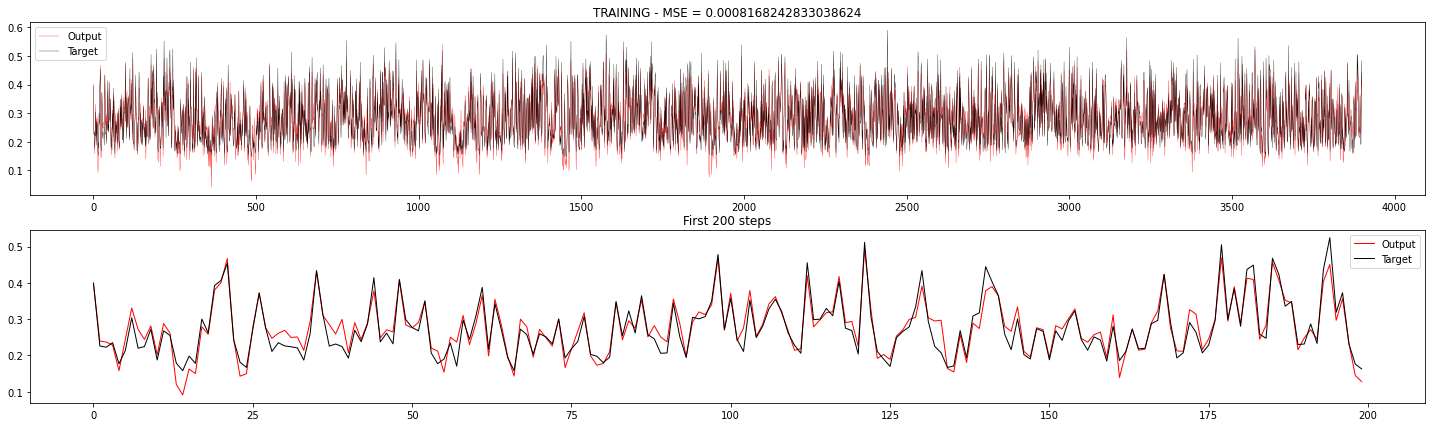

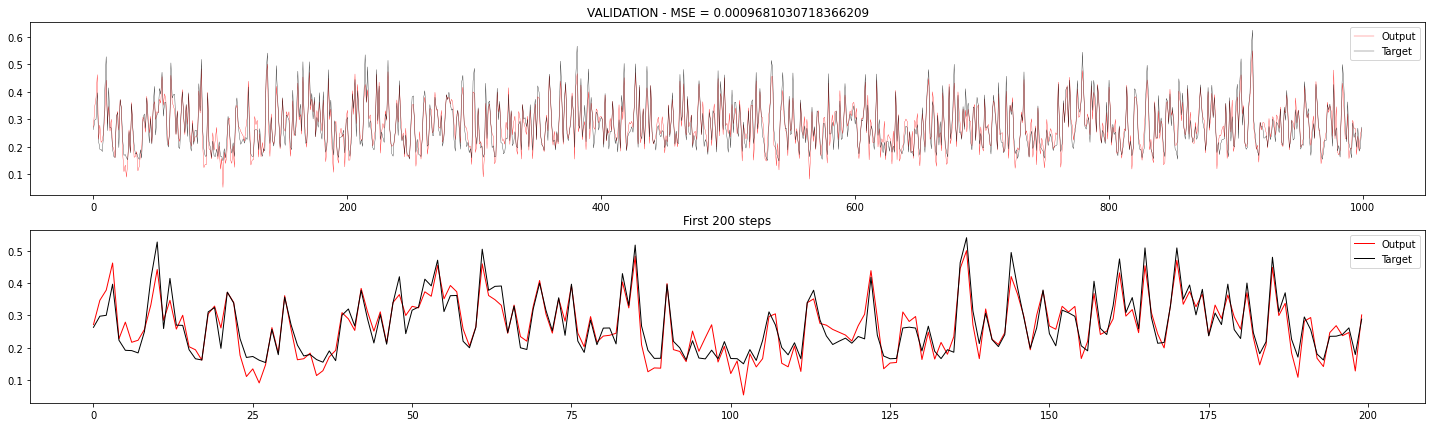

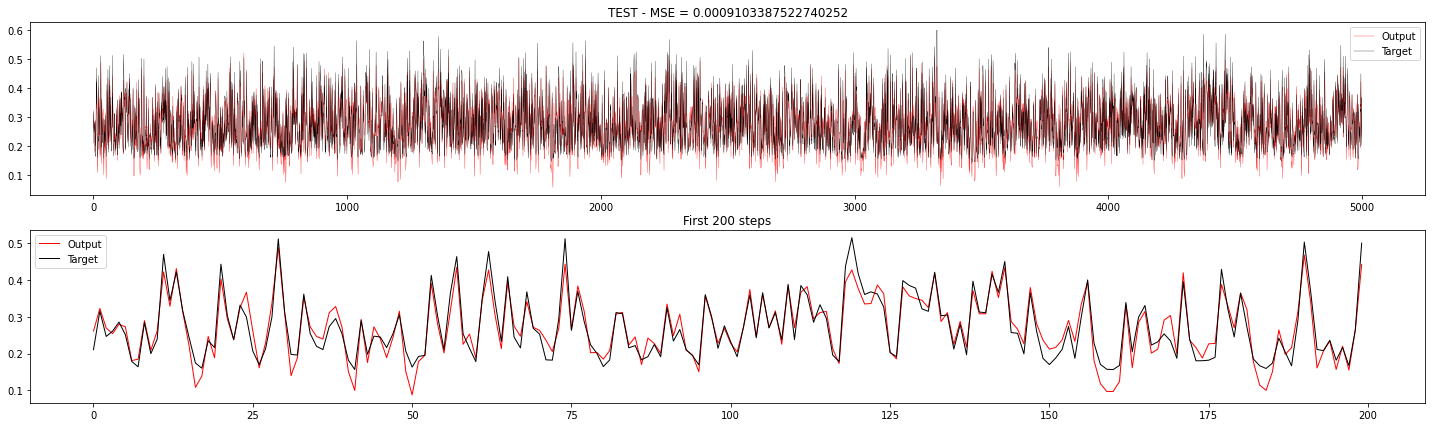

In [6]:
best_hp = np.load('best_hyperparams.npy')
print(f'Best hyperparameters: {best_hp}')

esn(best_hp,plot=True,test=True, save=True)

In [35]:
#to load esn variables
'''
Wx = np.load('Wx.npy')
Wh = np.load('Wh.npy')
Wo = np.load('Wo.npy')
b  = np.load('b.npy')
'''

"\nWx = np.load('Wx.npy')\nWh = np.load('Wh.npy')\nWo = np.load('Wo.npy')\nb  = np.load('b.npy')\n"